Problem 2  (50 points)

Please implement the following steps for the housing dataset we overviewed during the lectures.

2.a. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture without on-hot encoding. Please plot the training and validation results and report final accuracy and model complexity(20pt)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [5]:
train_dataset = pd.read_csv("house-train.csv")

In [6]:
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning', 'Alley', 'MasVnrType'
                ,'LotShape','LandContour','Condition1','HouseStyle','SaleCondition',]
df_prepro = train_dataset[usefull_cols].copy()
df_prepro['GarageArea'] = df_prepro['GarageArea'].fillna(df_prepro['GarageArea'].mean())
df_prepro['TotalBsmtSF'] = df_prepro['TotalBsmtSF'].fillna(df_prepro['TotalBsmtSF'].mean())
df_prepro['LotFrontage'] = df_prepro['LotFrontage'].fillna(df_prepro['LotFrontage'].mean())
df_y = train_dataset['SalePrice'].copy()

In [9]:
df_prepro = df_prepro.apply(pd.to_numeric, errors='coerce').fillna(0)


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_prepro, df_y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_val_scaled = scaler.transform(x_val)

In [15]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

train_data = TensorDataset(x_train_tensor, y_train_tensor.view(-1, 1))
val_data = TensorDataset(x_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [16]:
class Housing(nn.Module):
    def __init__(self, input_size):
        super(Housing, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32,1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc4(x)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [25]:
input_size = len(usefull_cols)
model = Housing(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        rmse_loss = torch.sqrt(loss)  
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if epoch % 5 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1/100, Train Loss: 194372.6448, Val Loss: 187989.8703
Epoch 6/100, Train Loss: 35032.8430, Val Loss: 35091.4768
Epoch 11/100, Train Loss: 32056.1408, Val Loss: 30660.1918
Epoch 16/100, Train Loss: 31878.7946, Val Loss: 30727.5121
Epoch 21/100, Train Loss: 31324.1794, Val Loss: 29829.9996
Epoch 26/100, Train Loss: 30899.1007, Val Loss: 30739.3150
Epoch 31/100, Train Loss: 30652.3460, Val Loss: 30877.0607
Epoch 36/100, Train Loss: 30450.2646, Val Loss: 30150.0659
Epoch 41/100, Train Loss: 30605.5134, Val Loss: 30695.8297
Epoch 46/100, Train Loss: 30431.5509, Val Loss: 30598.4195
Epoch 51/100, Train Loss: 30204.2302, Val Loss: 29825.3611
Epoch 56/100, Train Loss: 29589.4663, Val Loss: 29431.8621
Epoch 61/100, Train Loss: 29704.6274, Val Loss: 30340.6221
Epoch 66/100, Train Loss: 29756.6408, Val Loss: 30662.0529
Epoch 71/100, Train Loss: 29356.9462, Val Loss: 30401.3377
Epoch 76/100, Train Loss: 29538.8446, Val Loss: 29854.5262
Epoch 81/100, Train Loss: 29141.1869, Val Loss: 30164.19

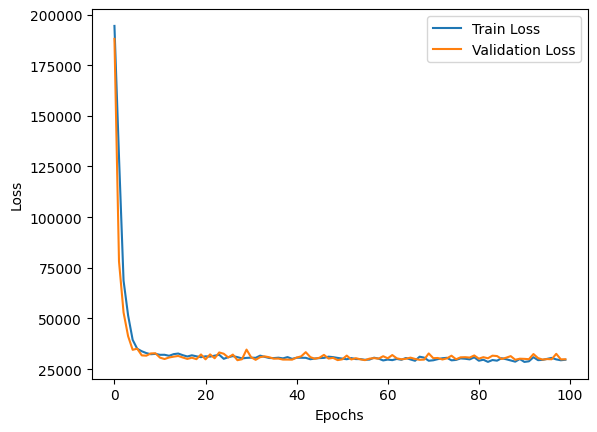

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
torch.save(model, 'model_Housing_1.pth')

In [415]:
# Report final accuracy
model.eval()
total_val_loss = 0
with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
print("Final Validation loss :", avg_val_loss)
total_parameters = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_parameters}')

Final Validation loss : 28684.143994140624
Total number of parameters in the model: 12929


2.b. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split). Use the same number of features we did in the lecture, but this time also add on-hot encoding. Please plot the training and validation results and report the final accuracy and model complexity. Do you see the meaningful changes against 2.b. (20pt)

In [29]:
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning','Alley'
                ,'LotShape','LandContour','Condition1','HouseStyle','SaleCondition','MasVnrType']
df_train_prepro = train_dataset[usefull_cols].copy()

df_train_prepro['GarageArea'] = df_train_prepro['GarageArea'].fillna(df_train_prepro['GarageArea'].mean())
df_train_prepro['TotalBsmtSF'] = df_train_prepro['TotalBsmtSF'].fillna(df_train_prepro['TotalBsmtSF'].mean())

df_train_prepro = pd.get_dummies(df_train_prepro,columns=['Neighborhood','MSZoning','LotShape','LandContour','Condition1','HouseStyle','SaleCondition'])

df_train_prepro = df_train_prepro.replace({True: 1, False: 0})



df_train_prepro = df_train_prepro.apply(pd.to_numeric, errors='coerce').fillna(0)


In [30]:
df_y = train_dataset['SalePrice'].copy()

In [31]:
X_train, X_val, y_train, y_val = train_test_split(df_train_prepro, df_y, test_size=0.2, random_state=42)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

train_data = TensorDataset(x_train_tensor, y_train_tensor.view(-1, 1))
val_data = TensorDataset(x_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [44]:
input_size = len(X_val_scaled[0])
model = Housing(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [45]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


Epoch 1/100, Train Loss: 193794.55152027027, Val Loss: 180398.6203125
Epoch 11/100, Train Loss: 24802.596494932433, Val Loss: 33780.06904296875
Epoch 21/100, Train Loss: 21358.520349451013, Val Loss: 30660.39873046875
Epoch 31/100, Train Loss: 20079.445233319257, Val Loss: 29762.678515625
Epoch 41/100, Train Loss: 17769.064505912163, Val Loss: 26999.83645019531
Epoch 51/100, Train Loss: 16824.234744510137, Val Loss: 27010.27158203125
Epoch 61/100, Train Loss: 15876.147606102197, Val Loss: 26703.913671875
Epoch 71/100, Train Loss: 16090.892921241553, Val Loss: 27530.86240234375
Epoch 81/100, Train Loss: 15355.709855363175, Val Loss: 27154.175634765626
Epoch 91/100, Train Loss: 14918.812341638513, Val Loss: 27524.29140625


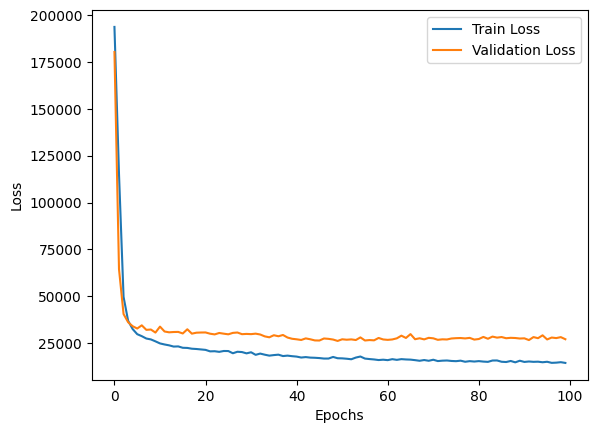

In [46]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
torch.save(model, 'model_Housing_2.pth')

In [47]:
model.eval()
total_val_loss = 0
with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
print("Final Validation loss :", avg_val_loss)
total_parameters = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_parameters}')

Final Validation loss : 27041.628344726563
Total number of parameters in the model: 20097


2.c increase the complexity of the network for problem 2. b and compare your results against 2.b. (10pt)

In [56]:
class Housing_extended(nn.Module):
    def __init__(self, input_size):
        super(Housing_extended, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 64)
        self.fc6 = nn.Linear(64, 1)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc6(self.relu(self.fc5(x)))  
        return x

In [57]:
input_size = len(X_val_scaled[0])
model = Housing_extended(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [58]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


Epoch 1/100, Train Loss: 84304.62536951013, Val Loss: 42185.48515625
Epoch 11/100, Train Loss: 23228.753536739863, Val Loss: 27933.7599609375
Epoch 21/100, Train Loss: 20940.188846072637, Val Loss: 29081.50185546875
Epoch 31/100, Train Loss: 22681.056798986487, Val Loss: 30204.5642578125
Epoch 41/100, Train Loss: 17805.240181587837, Val Loss: 30021.08359375
Epoch 51/100, Train Loss: 19114.20505173142, Val Loss: 31760.764892578125
Epoch 61/100, Train Loss: 21602.942198057433, Val Loss: 31783.2638671875
Epoch 71/100, Train Loss: 18584.5537109375, Val Loss: 31718.2865234375
Epoch 81/100, Train Loss: 14775.44285789696, Val Loss: 30431.9568359375
Epoch 91/100, Train Loss: 16189.185995565878, Val Loss: 29267.2005859375


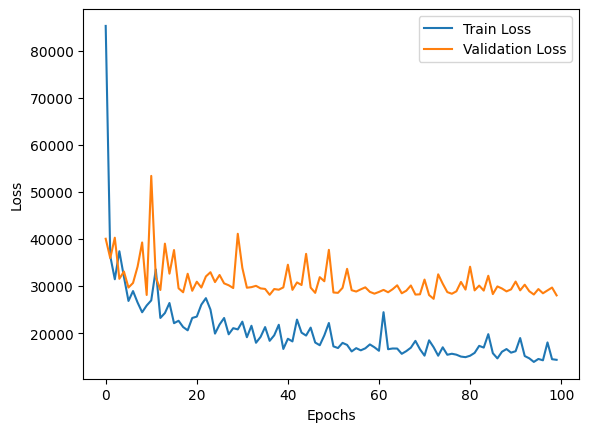

In [55]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
torch.save(model, 'model_Housing_3.pth')

In [52]:
model.eval()
total_val_loss = 0
with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMS
            total_val_loss += rmse_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
print("Final Validation loss :", avg_val_loss)
total_parameters = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_parameters}')

Final Validation loss : 27342.2451171875
Total number of parameters in the model: 898433
